In [1]:
import numpy as np 
import pandas as pd
import joblib
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

2024-01-30 11:34:04.330854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 11:34:04.332859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 11:34:04.357335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 11:34:04.357365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 11:34:04.358255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Data Preprocessing

In [2]:
df = pd.read_csv('Luxury watch.csv')
df

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.5,8.25,20.0,White,Sapphire,Date,38 hours,"21,500"
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,"13,500"
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.5,9.70,20.0,Blue,Sapphire,Date,64 hours,"1,800"
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,41.5,11.00,22.0,Blue,Sapphire,Date,40 hours,"19,000"


### Make the target column, water resistance and power reserve to be of type float instead of object

In [3]:
df['Price (USD)'] = df['Price (USD)'].apply(lambda x: float(str(x).replace(',','')))

df['Water Resistance'] = df['Water Resistance'].apply(lambda x: float(str(x).replace('meters', '')))

# Function to convert days to hours
def convert_days_to_hours(value):
    if pd.notna(value):  # Check if the value is not NaN
        if 'days' in value:
            days = int(value.split()[0])
            return days * 24
        elif 'hours' in value:
            return int(value.split()[0])
        else: return np.nan
    else:
        return value  # Return NaN if the input is NaN
# Apply the function to the 'Power Reserve' column
df['Power Reserve'] = df['Power Reserve'].apply(convert_days_to_hours)
df['Power Reserve'] = df['Power Reserve'].apply(lambda x: float(str(x).replace('hours', '')))

### Remove rows that contain nan values

In [4]:
# df.dropna(inplace=True)
df.dropna(subset = ['Price (USD)'], inplace=True)

### Remove duplicated rows

In [5]:
df = df.drop_duplicates()

### Create column transformer

In [6]:
targetcol = 'Price (USD)'
X = df.loc[:,~df.columns.isin([targetcol])]
y = df.loc[:,df.columns.isin([targetcol])]
catcols = list(X.select_dtypes(include=['object']).columns)
numcols = list(X.select_dtypes(include=['float64','int']).columns)

In [7]:
numcols

['Water Resistance',
 'Case Diameter (mm)',
 'Case Thickness (mm)',
 'Band Width (mm)',
 'Power Reserve']

In [8]:
catcols

['Brand',
 'Model',
 'Case Material',
 'Strap Material',
 'Movement Type',
 'Dial Color',
 'Crystal Material',
 'Complications']

In [9]:
class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.select_dtypes(include='object').columns:
            X[column] = X[column].str.lower()
        return X

In [10]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("lowercase", LowercaseTransformer()),  # Custom transformer for lowercase
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numcols),
        ("cat", categorical_transformer, catcols),
    ]
)

# Models

### Split the dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define models 

In [12]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
etree = ExtraTreesRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
knn = KNeighborsRegressor()
svr = SVR(kernel='linear', C=1.0)
lgbm = lgb.LGBMRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)


Models = [lr, ridge, lasso, tree, rf, etree, gb, xgb, knn, svr, lgbm, mlp]

### Test models

In [13]:
results = pd.DataFrame()

for model in Models:
    print('Model is: {}'.format(model))
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    m = pipeline.fit(X_train, y_train)
    print('Training score : {}'.format(m.score(X_train, y_train)))
    prediction = m.predict(X_test)

    r2score = r2_score(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    print('R2 score : {}'.format(r2score))
    print('MAE : {}'.format(mae))
    print('MSE : {}'.format(mse))
    print('RMSE : {}'.format(rmse))

    model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    results = pd.concat([results, model_df], ignore_index=True)
    
    print('=' * 80)
    
display(results.sort_values(by='RMSE', ascending=True))

Model is: LinearRegression()
Training score : 0.9197281804917987
R2 score : 0.8667327434884107
MAE : 2179.7762311512483
MSE : 10789825.918603633
RMSE : 3284.787043113089
Model is: Ridge()
Training score : 0.9092597893044413
R2 score : 0.8858082211645759
MAE : 1943.4919238188795
MSE : 9245402.413328478
RMSE : 3040.6253326130923
Model is: Lasso()
Training score : 0.9175641286256786
R2 score : 0.8818181871393133
MAE : 1904.404552452319
MSE : 9568450.802473824
RMSE : 3093.2912572976093
Model is: DecisionTreeRegressor()
Training score : 0.9796725033729013
R2 score : 0.7761121513627295
MAE : 2405.110544217687
MSE : 18126815.058106575
RMSE : 4257.559753909107
Model is: RandomForestRegressor()
Training score : 0.9601240828269506
R2 score : 0.9070780143823307
MAE : 1733.4487409132814
MSE : 7523318.743628918
RMSE : 2742.8668840519617
Model is: ExtraTreesRegressor()
Training score : 0.9796725033729013
R2 score : 0.8621343312751905
MAE : 1938.3909863945585
MSE : 11162130.928711746
RMSE : 3340.9775

,Model Name,R2 score,MAE,MSE,RMSE
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.907078,1733.448741,7.523319e+06,2742.866884
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.896461,2000.214591,8.382882e+06,2895.320700
1,Ridge(),0.885808,1943.491924,9.245402e+06,3040.625333
2,Lasso(),0.881818,1904.404552,9.568451e+06,3093.291257
0,LinearRegression(),0.866733,2179.776231,1.078983e+07,3284.787043
10,LGBMRegressor(),0.866279,2242.105605,1.082653e+07,3290.368973
5,"(ExtraTreeRegressor(random_state=148917976), E...",0.862134,1938.390986,1.116213e+07,3340.977541
7,"XGBRegressor(base_score=None, booster=None, ca...",0.854140,1931.442710,1.180941e+07,3436.482120
8,KNeighborsRegressor(),0.837381,2297.428571,1.316628e+07,3628.536490
3,DecisionTreeRegressor(),0.776112,2405.110544,1.812682e+07,4257.559754


### Neural Network

Epoch 1/140
13/13 [==============================] - 0s 1ms/step - loss: 272272928.0000
Epoch 2/140
13/13 [==============================] - 0s 1ms/step - loss: 272246656.0000
Epoch 3/140
13/13 [==============================] - 0s 967us/step - loss: 272205472.0000
Epoch 4/140
13/13 [==============================] - 0s 1ms/step - loss: 272135104.0000
Epoch 5/140
13/13 [==============================] - 0s 991us/step - loss: 272011680.0000
Epoch 6/140
13/13 [==============================] - 0s 1ms/step - loss: 271822304.0000
Epoch 7/140
13/13 [==============================] - 0s 1ms/step - loss: 271535040.0000
Epoch 8/140
13/13 [==============================] - 0s 920us/step - loss: 271102880.0000
Epoch 9/140
13/13 [==============================] - 0s 865us/step - loss: 270532256.0000
Epoch 10/140
13/13 [==============================] - 0s 908us/step - loss: 269791552.0000
Epoch 11/140
13/13 [==============================] - 0s 984us/step - loss: 268837376.0000
Epoch 12/140
13/13

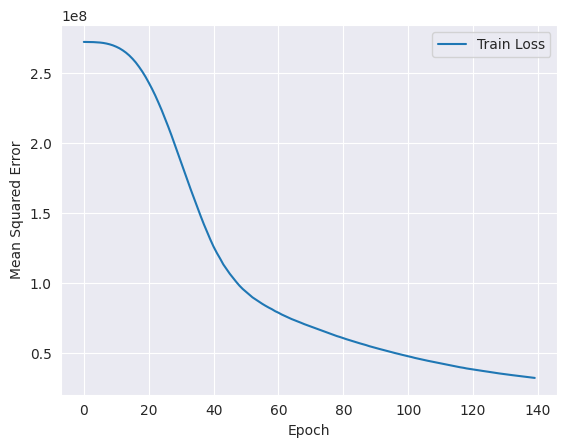

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_preprocessed = np.array(y_train, dtype=np.float32)
y_test_preprocessed = np.array(y_test, dtype=np.float32)

nn = model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])
nn.compile(optimizer='adam', loss='mean_squared_error')
history = nn.fit(X_train_preprocessed, y_train_preprocessed, epochs=140, batch_size=32, verbose=1)
prediction = nn.predict(X_test_preprocessed)

plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [15]:
r2score = r2_score(y_test_preprocessed, prediction)
mae = mean_absolute_error(y_test_preprocessed, prediction)
mse = mean_squared_error(y_test_preprocessed, prediction)
rmse = np.sqrt(mean_squared_error(y_test_preprocessed, prediction))
print('R2 score : {}'.format(r2score))
print('MAE : {}'.format(mae))
print('MSE : {}'.format(mse))
print('RMSE : {}'.format(rmse))

model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
results = pd.concat([results, model_df], ignore_index=True)
display(results.sort_values(by='RMSE', ascending=True))

R2 score : 0.6220941651563332
MAE : 4073.818603515625
MSE : 30596694.0
RMSE : 5531.427734375


,Model Name,R2 score,MAE,MSE,RMSE
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.907078,1733.448741,7.523319e+06,2742.866884
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.896461,2000.214591,8.382882e+06,2895.320700
1,Ridge(),0.885808,1943.491924,9.245402e+06,3040.625333
2,Lasso(),0.881818,1904.404552,9.568451e+06,3093.291257
0,LinearRegression(),0.866733,2179.776231,1.078983e+07,3284.787043
10,LGBMRegressor(),0.866279,2242.105605,1.082653e+07,3290.368973
5,"(ExtraTreeRegressor(random_state=148917976), E...",0.862134,1938.390986,1.116213e+07,3340.977541
7,"XGBRegressor(base_score=None, booster=None, ca...",0.854140,1931.442710,1.180941e+07,3436.482120
8,KNeighborsRegressor(),0.837381,2297.428571,1.316628e+07,3628.536490
3,DecisionTreeRegressor(),0.776112,2405.110544,1.812682e+07,4257.559754


# Final model

In [21]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", rf)]
)
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Water Resistance',
                                                   'Case Diameter (mm)',
                                                   'Case Thickness (mm)',
                                                   'Band Width (mm)',
                                                   'Power Reserve']),
                                                 ('cat',
                                                  Pipeline(steps=[('lowercase',
                                                                   LowercaseTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Model',
                                                   'Case Material',
                                                   'Strap Material',
                                                   'Movement Type',
                                                   'Dial Color',
                                                   'Crystal Material',
                                                   'Complications'])])),
                ('model', RandomForestRegressor())])

In [22]:
joblib.dump(pipeline, "model.joblib")

['model.joblib']

In [23]:
joblib.dump(list(X.columns), 'model_column_names.joblib')

['model_column_names.joblib']